# Imports and get project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd
import freud

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid
render.preview_tracer.resize(800, 800)

config = workflow.get_config()

In [3]:
project: signac.Project = signac.get_project(root=config['root'])

# Build local yield stress/strain computation system

In [86]:
for idx, job in enumerate(project.find_jobs({"phi":1.3})):
    print(idx, job.sp)
    sp = job.sp
    doc = job.doc

    sim = hoomd.Simulation(hoomd.device.GPU(), seed=doc['seed'])
    snapshot = gsd.hoomd.open(job.fn('quenched-more.gsd'), 'rb')[0]
    sim.create_state_from_snapshot(snapshot)

    fire = hoomd.md.minimize.FIRE(1e-2, 1e-3, 1.0, 1e-3)
    tree = hoomd.md.nlist.Tree(0.3)
    hertz = pair.bi_hertz(tree)
    nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
    fire.forces = [hertz]
    fire.methods = [nve]
    break

0 {'N': 32768, 'replica': 2, 'phi': 1.3}


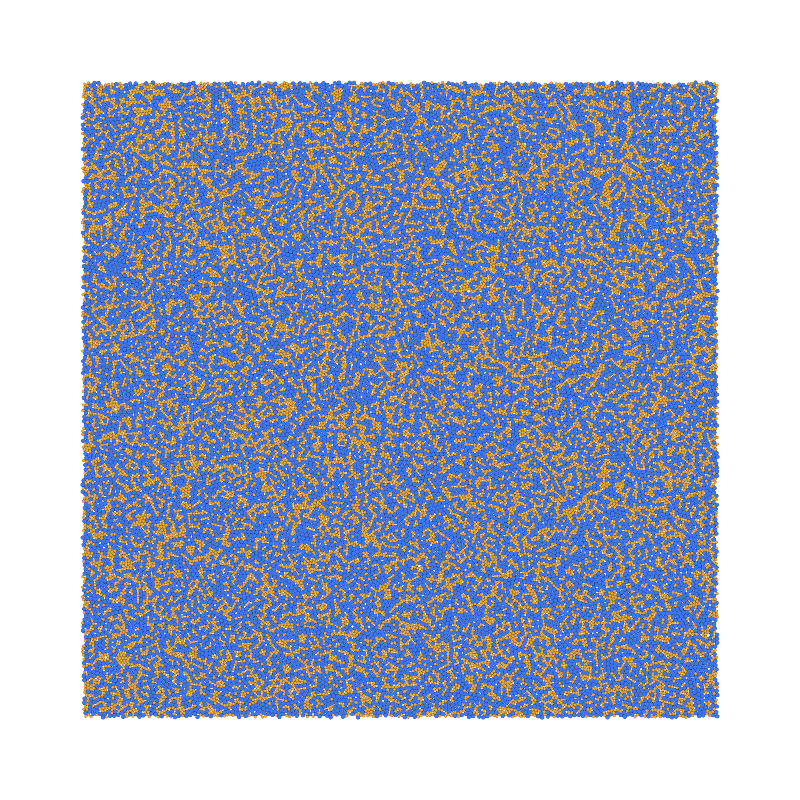

In [87]:
render.render_disk_frame(snapshot, Ly=200.0)

In [88]:
samples = 100
r_free = 5.0
r_max = r_free + 2.0
sep = 2.0*r_max + 2.0
nlist_query = freud.locality.AABBQuery.from_system(snapshot)
query_indices = np.random.permutation(snapshot.particles.N)[:samples]
query_pos = snapshot.particles.position[query_indices]
nlist = nlist_query.query(query_pos, {'r_max': r_max}).toNeighborList()

box = freud.box.Box.from_box(snapshot.configuration.box)

In [89]:
xy_sides = int(np.sqrt(samples))

theta = np.deg2rad(0.0)
rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

size = np.sum(nlist.neighbor_counts)
pos = np.zeros((size, 3))
typeid = np.zeros(size, dtype=np.int32)
diameters = np.zeros(size)
include = np.ravel(np.argwhere(nlist.distances < r_free)).astype(np.uint32)
exclude = np.ravel(np.argwhere(nlist.distances >= r_free)).astype(np.uint32)
i = 0
j = 0
for head, nn in zip(nlist.segments, nlist.neighbor_counts):
    indices = nlist.point_indices[head:head+nn]
    tmp = box.wrap(snapshot.particles.position[indices] - query_pos[i])
    tmp[:,:2] = np.dot(rot, tmp[:,:2].T).T
    tmp[:,0] += sep*(i%xy_sides)
    tmp[:,1] += sep*(i//xy_sides)
    pos[j:j+nn] = tmp
    typeid[j:j+nn] = snapshot.particles.typeid[indices]
    diameters[j:j+nn] = snapshot.particles.diameter[indices]
    i += 1
    j += nn

pos -= np.mean(pos, axis=0)

# typeid[exclude] = 2

In [90]:
size

20006

In [91]:
include.dtype

dtype('uint32')

In [92]:
snap = gsd.hoomd.Snapshot()
Lmax = np.max(pos)*2 + 15.0
snap.particles.N = len(pos)
snap.particles.position = pos
snap.configuration.box = [Lmax, Lmax, 0.0, 0.0, 0.0, 0.0]
snap.particles.types = ['A', 'B']
snap.particles.typeid = typeid
snap.particles.diameter = diameters

In [93]:
snap.validate()

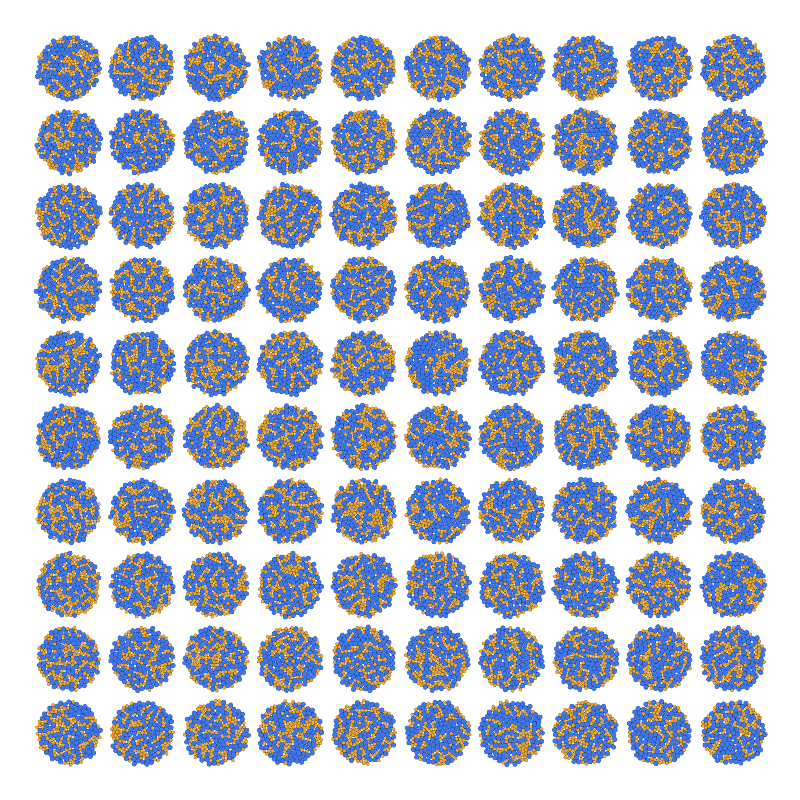

In [94]:
render.render_disk_frame(snap)

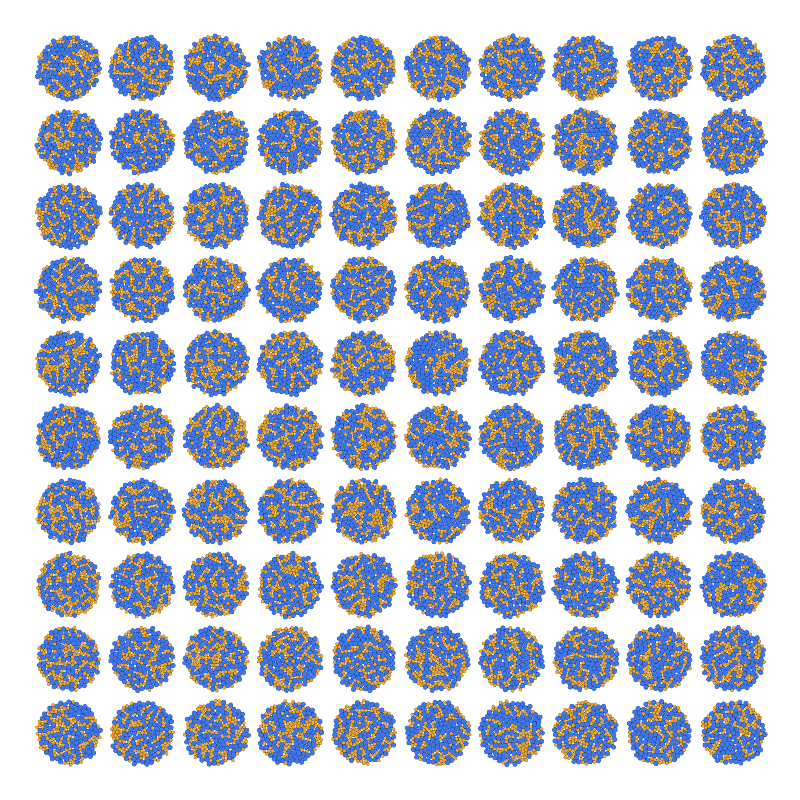

In [95]:
render.render_disk_frame(snap)

In [110]:
sim = hoomd.Simulation(hoomd.device.GPU(), seed=doc['seed'])
sim.create_state_from_snapshot(snap)

In [111]:
hoomd.write.GSD.write(sim.state, "init.gsd")

In [112]:
include.shape

(10213,)

In [113]:
fire = hoomd.md.minimize.FIRE(1e-2, 1e-3, 1.0, 1e-3)
tree = hoomd.md.nlist.Tree(0.3)
hertz = pair.bi_hertz(tree)
nve = hoomd.md.methods.NVE(filter=hoomd.filter.Tags(include))
fire.forces = [hertz]
fire.methods = [nve]
sim.operations.integrator = fire

In [114]:
sim.operations.updaters.clear()
sim.operations.writers.clear()

log = hoomd.logging.Logger()
log.add(hertz, quantities=["virials", "forces", "energies"])

writer = hoomd.write.GSD(filename="shear.gsd", trigger=hoomd.trigger.Periodic(1000, sim.timestep), mode='wb', log=log)
sim.operations.writers.append(writer)

new_box = sim.state.box
new_box.xy = 0.1

updater = hoomd.update.BoxResize(hoomd.trigger.Periodic(1000, sim.timestep+1), sim.state.box, new_box, hoomd.variant.Ramp(0.0, 1.0, sim.timestep, 1_000_000))
sim.operations.updaters.append(updater)

In [115]:
sim.run(2)
for i in range(1000):
    fire.reset()
    sim.run(1000)

In [116]:
data = gsd.hoomd.open("shear.gsd", "rb")

(array([ 702., 2372., 2744., 2080., 1207.,  701.,  277.,  100.,   27.,
           3.]),
 array([4.90051825e-05, 8.83789195e-04, 1.71857321e-03, 2.55335722e-03,
        3.38814123e-03, 4.22292525e-03, 5.05770926e-03, 5.89249327e-03,
        6.72727729e-03, 7.56206130e-03, 8.39684531e-03]),
 <BarContainer object of 10 artists>)

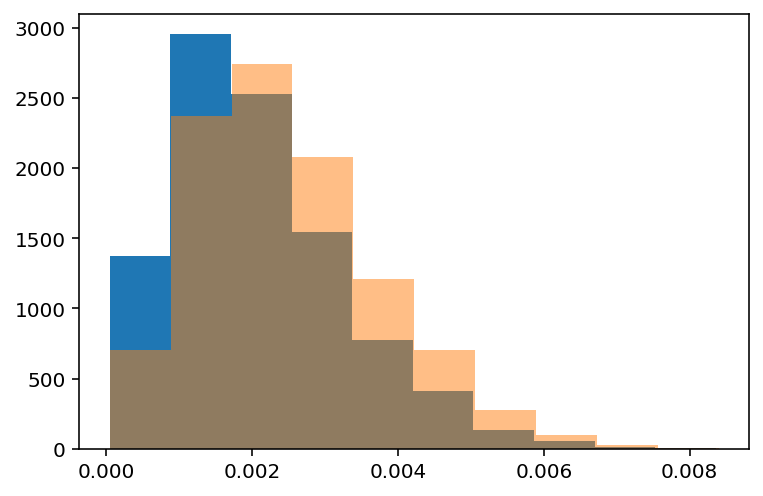

In [106]:

plt.hist(data[0].log["particles/pair_plugin/pair/Hertzian/energies"][exclude])
plt.hist(data[0].log["particles/pair_plugin/pair/Hertzian/energies"][include], alpha=.5)

In [128]:
virials = []
head = nlist.segments[0]
nn = nlist.neighbor_counts[0]
for frame in data:
    virials.append(frame.log["particles/pair_plugin/pair/Hertzian/virials"][include][0])
virials = np.array(virials)

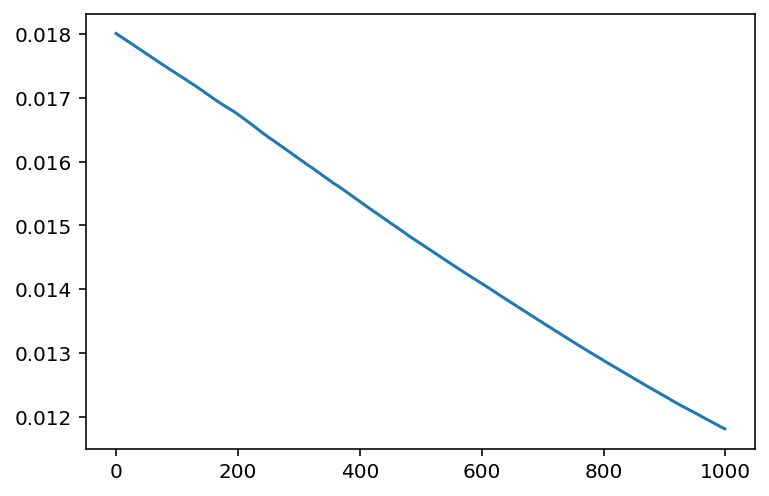

In [121]:
plt.plot(np.mean(virials[:,:2], axis=-1))

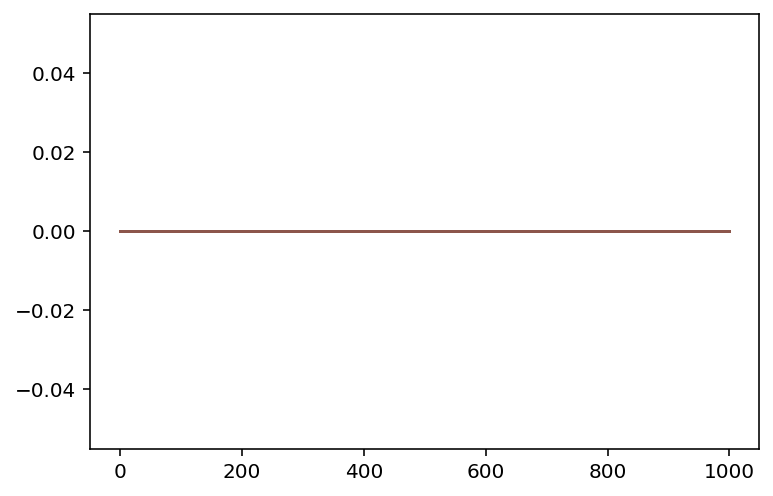

In [130]:
plt.plot(virials)

In [126]:
frame.log.keys()

dict_keys(['particles/pair_plugin/pair/Hertzian/virials', 'pair_plugin/pair/Hertzian/additional_virial', 'particles/pair_plugin/pair/Hertzian/forces', 'particles/pair_plugin/pair/Hertzian/energies'])

In [131]:
virials

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])